 ### get the dataset at [Here at anki](http://www.manythings.org/anki/)

Encoder, Decoder things in a seq2seq LSTM. Both are LSTM networks

In [ ]:
import tensorflow as tf

# Sample model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(tf.random.uniform([1000, 32]), tf.random.uniform([1000], maxval=10, dtype=tf.int64), epochs=5)


2024-12-24 15:08:01.121883: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-24 15:08:01.727073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735033081.897806   18410 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735033081.937894   18410 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 15:08:02.254625: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory limit to 4096 MB (4 GB) or a value suitable for your use case
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)]
        )
        print("Set GPU memory allocation limit to 3072 MB.")
    except RuntimeError as e:
        print(f"Error setting memory limit: {e}")


2024-12-24 15:03:16.348663: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-24 15:03:16.742003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735032796.976097   18246 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735032797.038367   18246 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 15:03:17.438613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Set GPU memory allocation limit to 3072 MB.


In [2]:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
LSTM_NODES = 512
TOTAL_SENTENCES = 5000
MAX_SEN_LENGTH = 50
MAX_NUM_WORDS = 5000
EMBEDDING_SIZE = 100

# other configs
file_path = './datasets/ben-eng/ben.txt'

In [4]:
input_english_sentences = []
output_french_sentences = []
output_french_sentences_inputs = []
count = 0
for line in open('./datasets/eng_hin.tsv', mode='r', encoding='utf-8'):
    count+=1
    if count> TOTAL_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[1]

    output = line.rstrip().split('\t')[3]

    output_sentence = output + " <eos>"
    output_sentence_input = "<sos> " + output

    input_english_sentences.append(input_sentence)
    output_french_sentences.append(output_sentence)
    output_french_sentences_inputs.append(output_sentence_input)



In [5]:
print(f"sentences in input: {len(input_english_sentences)}")
print(f"sentences in output: {len(output_french_sentences)}")
print(f"sentences for output input: {len(output_french_sentences_inputs)}")

sentences in input: 5000
sentences in output: 5000
sentences for output input: 5000


In [6]:
print(input_english_sentences[175])
print(output_french_sentences[175])
print(output_french_sentences_inputs[175])

Your bicycle is similar to mine.
तुम्हारी साईकल मेरी साईकल जैसी है। <eos>
<sos> तुम्हारी साईकल मेरी साईकल जैसी है।


In [7]:
input_eng_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_eng_tokenizer.fit_on_texts(input_english_sentences)
input_eng_integer_seq = input_eng_tokenizer.texts_to_sequences(input_english_sentences)

word2idx_eng_inputs = input_eng_tokenizer.word_index
print(f'Sum of unique words in the English Sentences{len(word2idx_eng_inputs)}')
max_input_len = max(len(sen) for sen in input_eng_integer_seq)
print(f'Length of the longest sentence in the English sentences: {max_input_len}')


Sum of unique words in the English Sentences3587
Length of the longest sentence in the English sentences: 30


In [8]:
output_french_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_french_tokenizer.fit_on_texts(output_french_sentences + output_french_sentences_inputs)
output_french_integer_seq = output_french_tokenizer.texts_to_sequences(output_french_sentences)
output_input_french_integer_seq = output_french_tokenizer.texts_to_sequences(output_french_sentences_inputs)

word2idx_french_outputs = output_french_tokenizer.word_index
print(f'Sum of unique words in French Sentences{len(word2idx_french_outputs)}')

num_words_output = len(word2idx_french_outputs)+1
max_out_len = max(len(sen) for sen in output_french_integer_seq)
print(f'Length of the Longest Frence Sentence:{max_out_len}')

Sum of unique words in French Sentences5010
Length of the Longest Frence Sentence:33


In [9]:
encoder_input_eng_sequences = pad_sequences(input_eng_integer_seq, maxlen=max_input_len)
print(f'encoder_input_eng_sequence.shape: {encoder_input_eng_sequences.shape}')
print(f'encoder_input_eng_sequence[175]: {encoder_input_eng_sequences[175]}')

print (word2idx_eng_inputs["i"])
print(word2idx_eng_inputs["love"])

encoder_input_eng_sequence.shape: (5000, 30)
encoder_input_eng_sequence[175]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   22  393    5 2007
    3  277]
2
250


In [10]:
decoder_input_french_sequences = pad_sequences(output_input_french_integer_seq, maxlen=max_out_len, padding='post')
print(f"decoder_input_french_sequence.shape: {decoder_input_french_sequences.shape}")
print(f"decoder_input_french_sequence[175]: {decoder_input_french_sequences[175]}")

# print(word2idx_french_outputs['<sos>'])
# print(word2idx_french_outputs['je'])
# print(word2idx_french_outputs['suis'])
# print(word2idx_french_outputs['timide.'])

decoder_input_french_sequence.shape: (5000, 33)
decoder_input_french_sequence[175]: [   2  107  539   39  539 1268    3    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


In [11]:
decoder_output_french_sequence = pad_sequences(output_french_integer_seq, maxlen=max_out_len, padding='post')

Creating the glove word embedding

[can be found Here](https://stanford.io/2MJW98X)

In [12]:
from numpy import array, asarray, zeros

embeddings_dictionary = dict()

glove_file = open(r'./datasets/glove_6B/glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [13]:
num_words = min(MAX_NUM_WORDS, len(word2idx_eng_inputs)+1)
embeddings_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_eng_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

In [14]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights = [embeddings_matrix], input_length=max_input_len)

/home/sapt/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1735032862.595831   18246 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3072 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [15]:
decoder_one_hot_targets = np.zeros((len(input_english_sentences), max_out_len, num_words_output), dtype='float32')

In [16]:
decoder_one_hot_targets.shape

(5000, 33, 5011)

In [17]:
for i, d in enumerate(decoder_output_french_sequence):
    for t, word in enumerate(d):
        decoder_one_hot_targets[i,t,word] = 1

In [18]:
encoder_inputs_eng_placeholder = Input(shape=(max_input_len,))
x=embedding_layer(encoder_inputs_eng_placeholder)
encoder=LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h,c]

In [19]:
decoder_inputs_french_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_french_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state = encoder_states)

#

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [20]:
model = Model([encoder_inputs_eng_placeholder, decoder_inputs_french_placeholder], decoder_outputs)

model.compile( optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

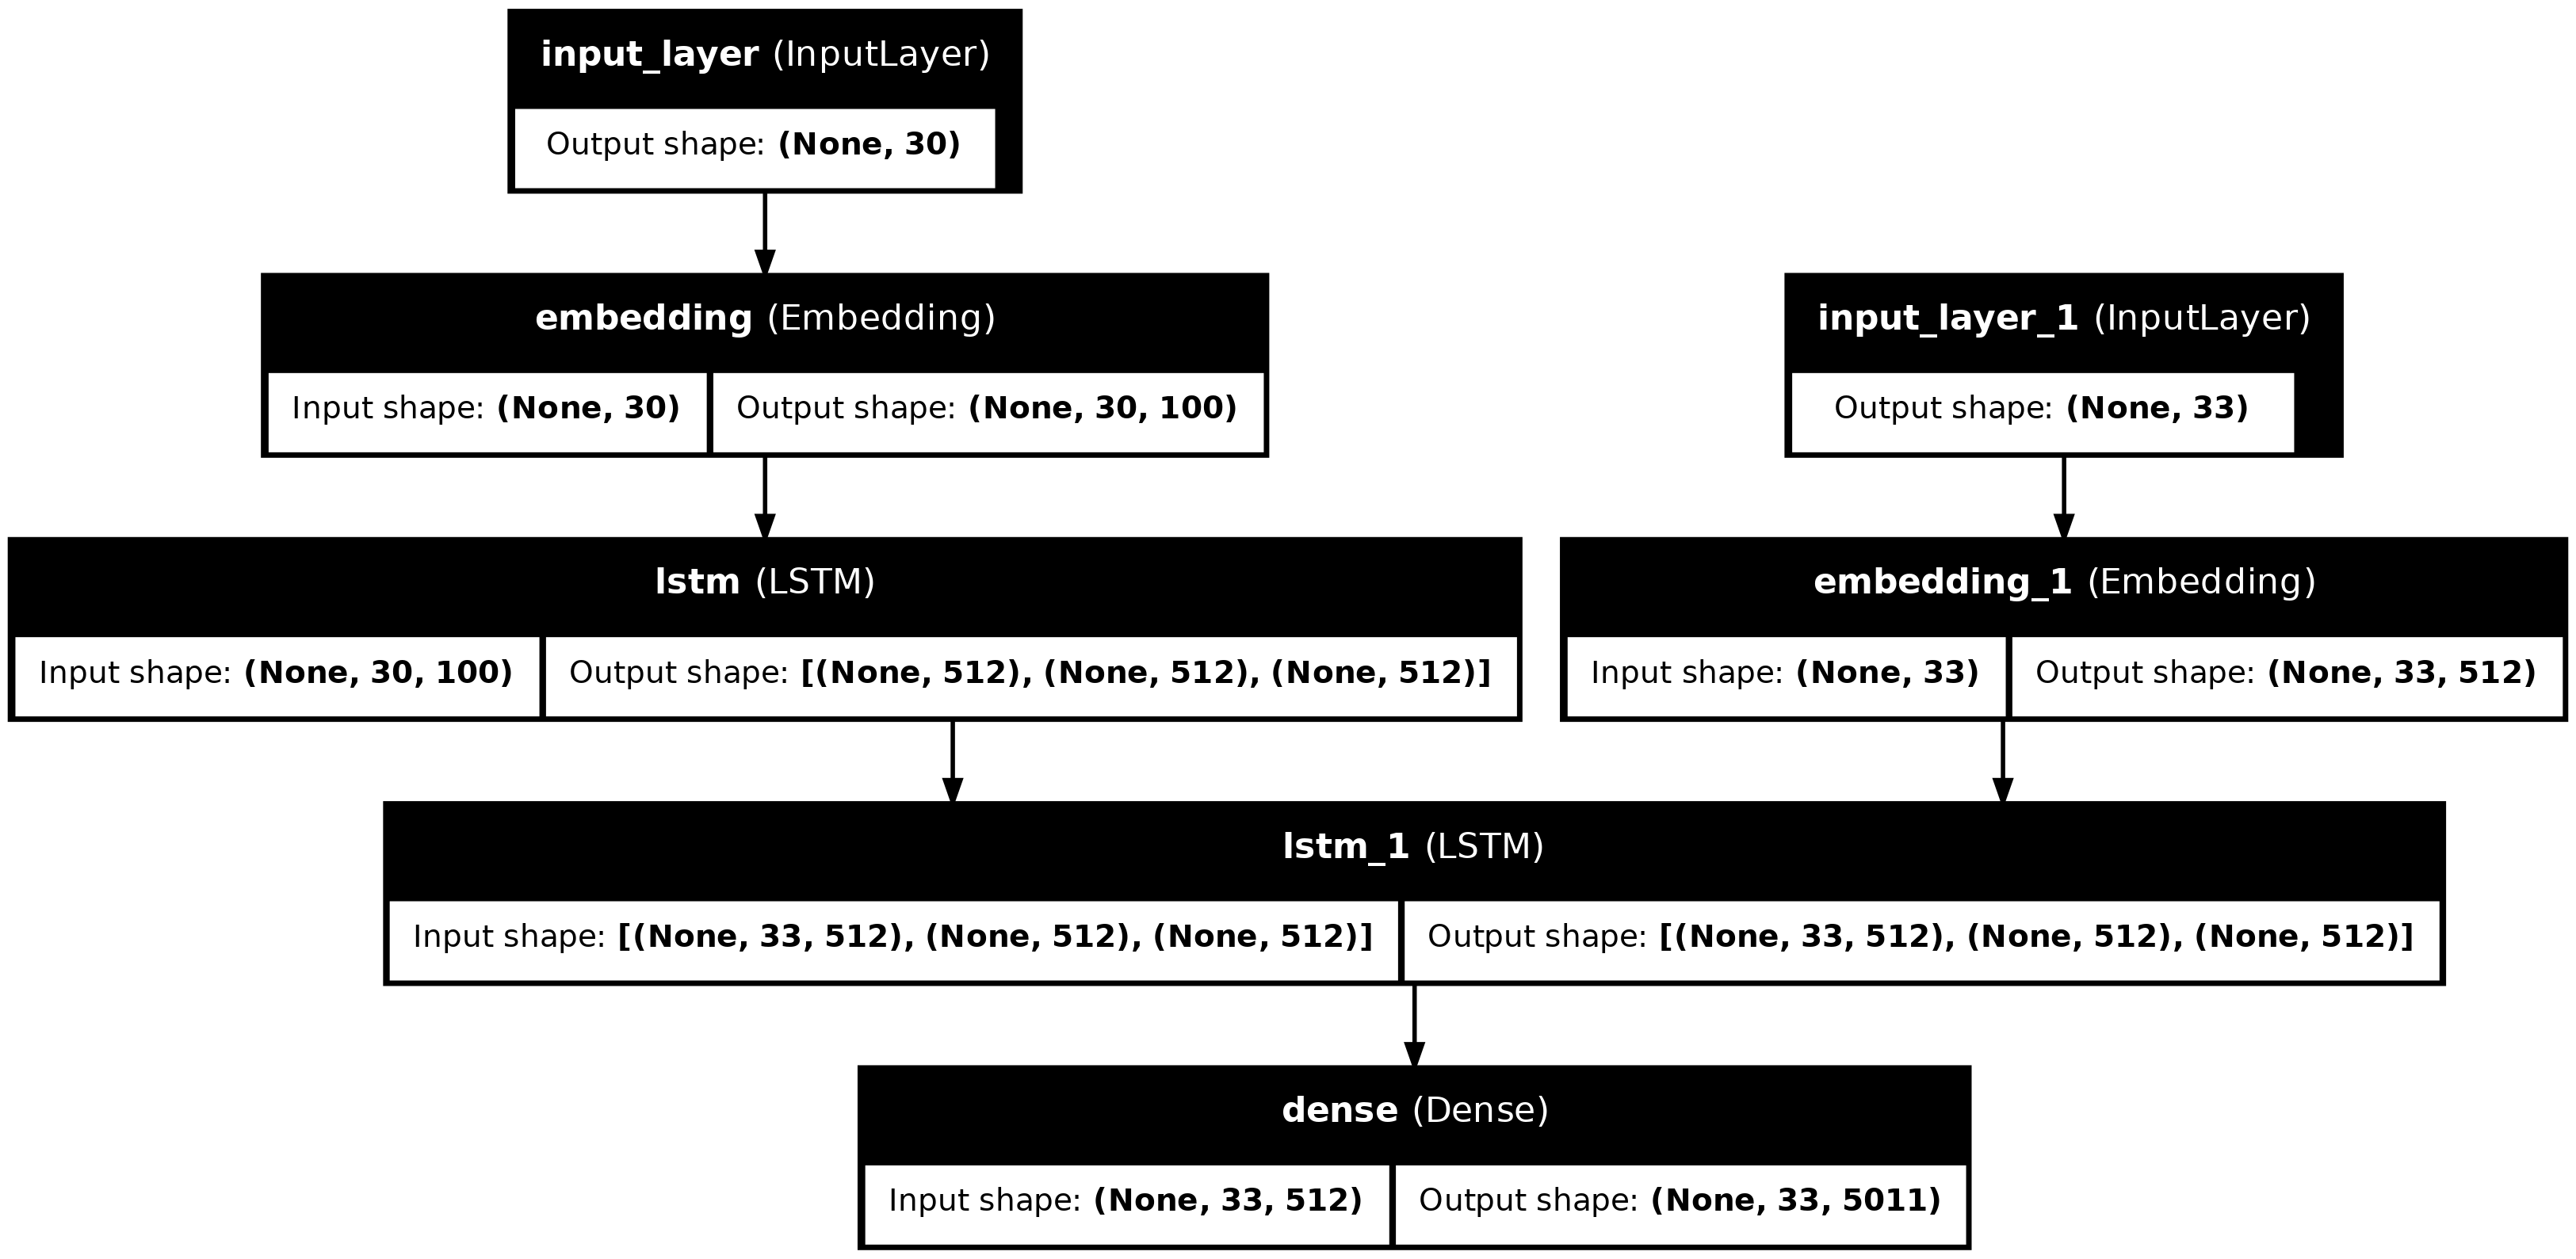

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='./model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.fit(
    [encoder_input_eng_sequences, decoder_input_french_sequences],
    decoder_one_hot_targets,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=0.1,
)

In [ ]:
encoder_prediction_model = Model(encoder_inputs_eng_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state = decoder_states_inputs)

decoder_states = [h,c]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='./model.png', show_shapes=True, show_layer_names=True)


In [ ]:
idx2word_eng_input = {v:k for k, v in word2idx_eng_inputs.items()}
idx2word_french_target = {v:k for k, v in word2idx_french_outputs.items()}

In [ ]:
def translate_sentence(input_seq):
    """Translates an input English sentence into French.

    Args:
        input_seq: The input English sentence as a sequence of word indices.

    Returns:
        The translated French sentence as a string.
    """
    # Encode the input as state vectors.
    states_value = encoder_prediction_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = word2idx_french_outputs['<sos>']
    eos = word2idx_french_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
      output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
      idx = np.argmax(output_tokens[0, 0, :])
      if eos == idx:
        break
      word = ''
      if idx > 0:
        word = idx2word_french_target[idx]
        output_sentence.append(word)
      target_seq[0, 0] = idx
      states_value = [h, c]
    return ' '.join(output_sentence)

In [ ]:
random_sentence_index = np.random.choice(len(input_english_sentences))
input_eng_seq = encoder_input_eng_sequences[random_sentence_index:random_sentence_index+1]
translation = translate_sentence(input_eng_seq)
print('-')
print('Input English sentence:', input_english_sentences[random_sentence_index])
print('Translated French sentence:', translation)